In [17]:
%load_ext autoreload
%autoreload 2

from pystorm.hal.net_builder import NetBuilder

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# create a tap list

Y = 8
X = 8
N = X * Y
LAMBDA = 2

def to_idx(x, y):
    return y * X + x

tap_list = [
    [(to_idx(1, 1), 1), (to_idx(6, 3), -1)],
    [(to_idx(2, 5), 1), (to_idx(5, 2), -1)]]
dims = len(tap_list)

In [19]:
# generate approximate encoders

approx_encs = NetBuilder.get_approx_encoders(tap_list, Y, X, LAMBDA)

Text(0.5,1,'first two dims')

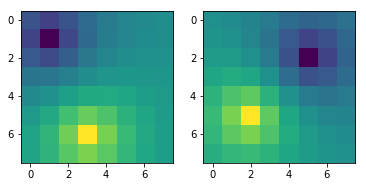

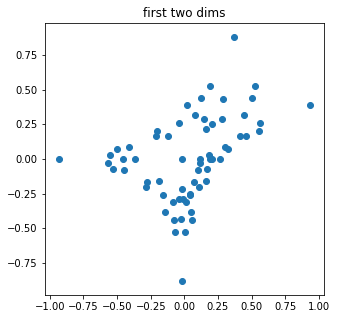

In [20]:
# plot the approximate encoders

yx_approx_encs = approx_encs.T.reshape((dims, Y, X))

fig, ax = plt.subplots(1, 2)
for d in range(dims):
    ax[d].imshow(yx_approx_encs[d, :, :].T)

# first two dims
plt.figure(figsize=(5,5))
plt.scatter(approx_encs[:, 0], approx_encs[:, 1])
plt.title('first two dims')

In [21]:
# get sample points
samples_per_enc = dims + 1
ANGLE_AWAY = np.pi / 6

sample_pts, thresh_encs = NetBuilder.get_sample_points_around_encs(approx_encs, ANGLE_AWAY, samples_per_enc)

Text(0.5,1,'first two dims\ntotal base encs = 9\ntotal sample points = 27')

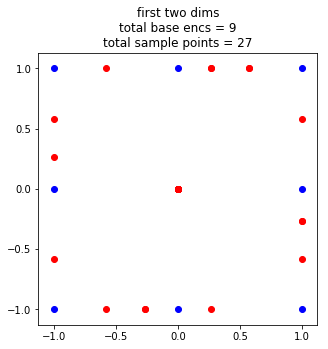

In [22]:
# plot resulting test points

plt.figure(figsize=(5, 5))
plt.scatter(thresh_encs[:, 0], thresh_encs[:, 1], c='b')
plt.scatter(sample_pts[:, 0], sample_pts[:, 1], c='r')
plt.title('first two dims' + 
          '\ntotal base encs = ' + str(thresh_encs.shape[0]) + 
          '\ntotal sample points = ' + str(sample_pts.shape[0]))
          

In [23]:
# now rig up a fake neuron response generator to test this on
# first just do ideal responses, no noise

offset_scale = 20
offsets = (2 * np.random.rand(N,) - 1) * offset_scale
gain_scale = 100
gains = np.random.rand(N,) * gain_scale

def nrn_fn(enc, offset, gain, x):
    return np.maximum(gain * np.dot(enc, x) + offset, 0)

firing_rates = np.zeros((sample_pts.shape[0], N))
for n in range(N):
    for s in range(sample_pts.shape[0]):
        firing_rates[s, n] = nrn_fn(approx_encs[n, :], offsets[n], gains[n], sample_pts[s, :])


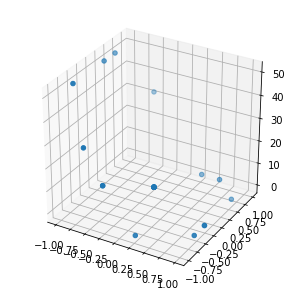

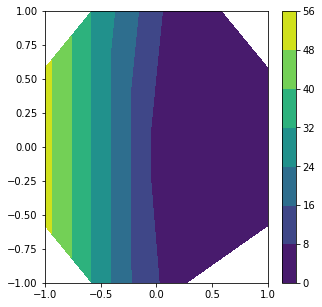

In [24]:
# plot neurons' behaviors

if dims == 2:
    
    # pick a neuron with a reasonable response
    nrn_idx = 0
    while True:
        if (np.abs(offsets[nrn_idx]) < .5 * offset_scale and 
            np.linalg.norm(approx_encs[nrn_idx, :]) > .2):
            break
        nrn_idx += 1
    #nrn_idx = np.random.randint(N)
    
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(sample_pts[:, 0], sample_pts[:, 1], firing_rates[:, nrn_idx])
    
    plt.figure(figsize=(5, 5))
    plt.tricontourf(sample_pts[:, 0], sample_pts[:, 1], firing_rates[:, nrn_idx])
    plt.colorbar()

In [25]:
# try fitting, compare estimates to actual encoders 

baselines = np.maximum(offsets, 0)

est_encs, est_offsets, residuals, insufficient = NetBuilder.estimate_encs_from_tuning_curves(sample_pts, 
                                                                                             firing_rates, 
                                                                                             baselines, 
                                                                                             fired_tolerance=.1)

print(np.sum(insufficient), "/", est_encs.shape[0], "neurons needed more points")

9 / 64 neurons needed more points


[[-4.51378780e+01  5.32907052e-15]
 [-2.50210311e+01  1.30270832e+00]
 [-1.58574622e+01  3.19306011e+00]
 [-8.50495532e+00  6.77758717e+00]]
[[-45.13787801   0.        ]
 [-25.02103112   1.30270832]
 [-15.85746216   3.19306011]
 [ -8.50495532   6.77758717]]
[ 2.63915873e-14  1.52259158e-14 -7.81597009e-15 -6.80936788e-15]


(array([1., 4., 6., 7., 7., 9., 4., 5., 4., 8.]),
 array([-14.07263913, -10.68775128,  -7.30286344,  -3.91797559,
         -0.53308774,   2.85180011,   6.23668795,   9.6215758 ,
         13.00646365,  16.39135149,  19.77623934]),
 <a list of 10 Patch objects>)

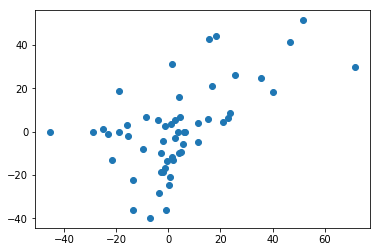

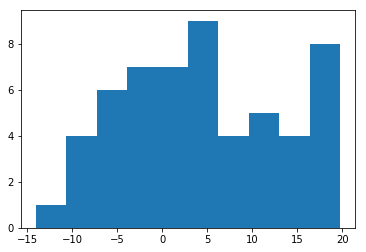

In [27]:
print(est_encs[:4, :])
print((approx_encs[:4, :].T * gains[:4]).T)
print(residuals[:4])

plt.figure()
plt.scatter(est_encs[:, 0], est_encs[:, 1])

plt.figure()
plt.hist(est_offsets[~np.isnan(est_offsets)])

In [1]:
# now try the same thing with the chip

%load_ext autoreload
%autoreload 2

from pystorm.hal.net_builder import NetBuilder

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

(4, 4, 1)


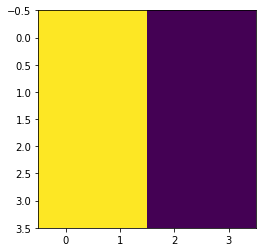

In [8]:
# test the D > 1 create_default_yx_taps function (with no bad taps)
# this is in the SY, SX space, not Y,X space

np.random.seed(1)

Y = 8
X = 8
D = 1
FMAX = 1000 # should determine from syn_tau
BIAS = -1

SY = Y // 2
SX = X // 2

yx_taps = NetBuilder.create_default_yx_taps(SY, SX, D, bad_syn=np.array([[False] * SY] * SX, dtype=bool))
print(yx_taps.shape)

if D == 1:
    plt.imshow(yx_taps[:, :, 0])
else:
    fig, ax = plt.subplots(1, D, figsize=(D*3,3))
    for d in range(D):
        ax[d].imshow(yx_taps[:, :, d])

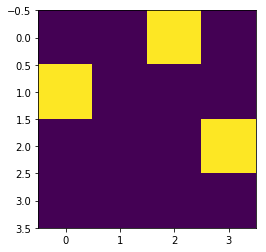

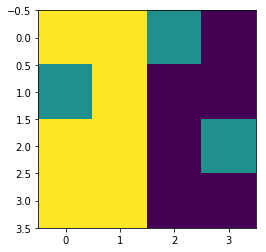

In [9]:
# try again with bad_syn set to the first :SY, :SX taps from the chip data

from pystorm.hal import HAL
HAL = HAL()
bad_syn = HAL.get_calibration('synapse', 'high_bias_magnitude')

yx_taps = NetBuilder.create_default_yx_taps(SY, SX, D, bad_syn=bad_syn.loc[:SY, :SX])

plt.figure()
plt.imshow(bad_syn.values.reshape((32, 32))[:SY, :SX])

if D == 1:
    plt.figure()
    plt.imshow(yx_taps[:, :, 0])
else:
    fig, ax = plt.subplots(1, D, figsize=(D*3,3))
    for d in range(D):
        ax[d].imshow(yx_taps[:, :, d])

In [10]:
# now that we know that works, try the whole thing

net_builder = NetBuilder(HAL)

tap_matrix = NetBuilder.syn_taps_to_nrn_taps(yx_taps)
NetBuilder.make_taps_even(tap_matrix)

net = net_builder.create_single_pool_net(Y, X, tap_matrix, biases=BIAS)
pool = net.get_pools()[0]
inp = net.get_inputs()[0]

# map the network
print("mapping network")
HAL.map(net)

# do it!
print("running encoders and offsets experiment")
est_encs, est_offsets, baselines, mean_residuals, insufficient_samples = \
    net_builder.determine_encoders_and_offsets(pool, inp, FMAX)

mapping network
running encoders and offsets experiment
getting baseline firing rates of population


/Users/aneckar/pystorm2/pystorm/hal/net_builder.py:384: RuntimeWarning: invalid value encountered in true_divide
  rand_orthog_pt /= np.linalg.norm(rand_orthog_pt)


AssertionError: 

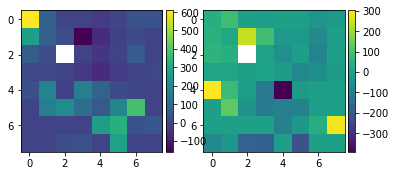

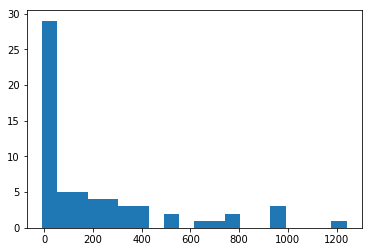

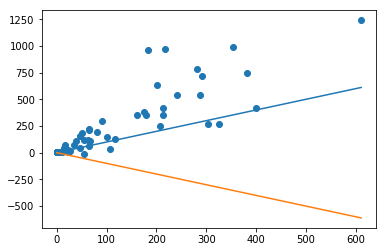

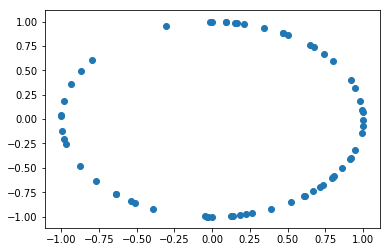

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

if D == 1:
    plt.figure()
    plt.imshow(est_encs.reshape(Y, X))
    plt.colorbar()
else:
    fig, ax = plt.subplots(1, D, figsize=(D*3,3))
    for d in range(D):
        im = ax[d].imshow(est_encs[:, d].reshape(Y, X))
        divider = make_axes_locatable(ax[d])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
plt.figure()
plt.hist(est_offsets[~np.isnan(est_offsets)], bins=20)

gain = np.linalg.norm(est_encs, axis=1)
bias = est_offsets

plt.figure()
plt.scatter(gain, bias)
x = np.linspace(0, max(gain), 100)
plt.plot(x, x)
plt.plot(x, -x)

unit_encs = (est_encs.T / gain).T

plt.figure()
plt.scatter(unit_encs[:, 0], unit_encs[:, 1])



In [6]:
# validate estimated encoders and offsets

NUM_VAL_SAMPLES = 20
val_pts = np.random.randn(NUM_VAL_SAMPLES, D)
val_pts_norms = np.linalg.norm(val_pts, axis=1)
val_pts = (val_pts.T / val_pts_norms).T

rmse, meas_A, est_A = net_builder.validate_est_encs(est_encs, est_offsets, pool, inp, val_pts, FMAX)

/Users/aneckar/pystorm2/pystorm/hal/net_builder.py:690: RuntimeWarning: invalid value encountered in maximum
  est_A = np.maximum(0, np.dot(sample_pts, est_encs.T) + est_offsets)


Text(0.5,1,'diff')

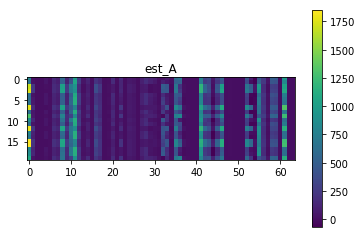

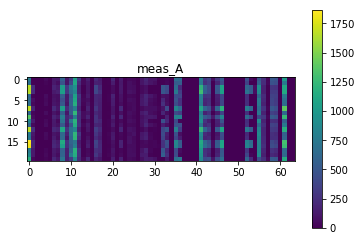

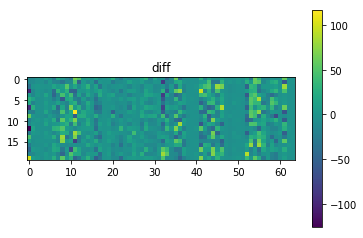

In [7]:
clean_encs = est_encs.copy()
unest = np.isnan(est_offsets)
clean_encs[unest, :] = 0
clean_offsets = est_offsets.copy()
clean_offsets[unest] = baselines[unest]

est_A = np.dot(val_pts, clean_encs.T) + clean_offsets

RMSE = np.sqrt(np.mean((est_A.flatten() - meas_A.flatten())**2))

plt.figure()
plt.imshow(est_A)
plt.colorbar()
plt.title('est_A')

plt.figure()
plt.imshow(meas_A)
plt.colorbar()
plt.title('meas_A')

plt.figure()
plt.imshow(meas_A - est_A)
plt.colorbar()
plt.title('diff')